# QuaPY: a Python-based Software Library for Quantification

In this part of the lecture, we are going to be reviewing QuaPy, an open-source software library for quantification.

QuaPy is something we have implemented, and represents the first publicly-available quantification framework for research and development. It is currently in its 0.1.7 version, and is constantly growing.

The very first thing we need is to install it. The following pip command will do the job:

In [1]:
! pip install quapy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 KB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for abstention: filename=abstention-0.1.3.1-py3-none-any.whl size=25454 sha256=1b42c58afe53b50a02fe0dbb19cd11c05b812e41e7b4c8369ec6568b2206cc5f
  Stored in directory: /root/.cache/pip/wheels/a0/dc/ed/2ddd390de2a6b43aa30f75155b50dfea2bc3b8ed9a5c667578
Successfully built abstention


The most important features of QuaPy include:

* QuaPy provides implementation of many methods, including basic and advanced ones. All methods in quapy implement the same interface, so it is easy to experiment with different methods.
* QuaPy provides most typical evaluation procedures, including the artificial-prevalence protocol we saw in the previous lecture, and other popular such protocols.
* It also implements many evaluation measures customarily employed for the evaluation of quantification systems.
* There are many standard datasets used the literature, including the "Kindle" dataset we used in our previous lecture. Currently supports 50 distinct datasets, and it is easy to import new ones to experiment with custom data.
* QuaPy brings native support to multiclass quantification. Recall that in our previous lecture we only explored the binary case, but that many problems are rather characterized by more than 2 classes. For example, some sentiment datasets include "negative, "neutral", and "positive" categories.
* QuaPy implements procedures for performing model selection (we will come back to this in a while).
* Finally, it also provides visualization tools that might be useful for analyzing the performance of a quantifier, or the conditions in which it may be more or less convenient to use one or the other.
* It is open-sourced in GitHub. It comes with a full API documentation, a Wiki explaining the main concepts behind it, and includes some code examples.

Useful links:
* Link to the [Wiki](https://github.com/HLT-ISTI/QuaPy/wiki)
* Link to the [Examples](https://github.com/HLT-ISTI/QuaPy/tree/master/examples)
* Link to the [API documentation](https://hlt-isti.github.io/QuaPy/build/html/modules.html)


In [2]:
import quapy as qp

Let's have a quick look at the framework. The following example uses the "Kindle" dataset; it automatically downloads it the first time, and then automatically generates the TfIDF-based BoW representation, by also dropping infrequent terms. The fetch function returns a dataset, which is nothing but a training and a test dataset. We then instantiate ACC, which is included in the aggregative module within the method module, and we simply train the model. In this case we use a scikit-learn LogisticRegression as a classifier. We then call the method quantify for obtaining the class prevalence estimations, and compare them with the test prevalence in terms of mean absolute error.

In [6]:
from sklearn.linear_model import LogisticRegression

dataset = qp.datasets.fetch_reviews('kindle', tfidf=True, min_df=5)
training, test = dataset.train_test

# create an "Adjusted Classify & Count" quantifier
model = qp.method.aggregative.ACC(LogisticRegression())
model.fit(training)

estim_prevalence = model.quantify(test.instances)
true_prevalence  = test.prevalence()

error = qp.error.mae(true_prevalence, estim_prevalence)

print(f'Mean Absolute Error (MAE)={error:.3f}')

loading /root/quapy_data/reviews/kindle/train.txt: 100%|██████████| 3821/3821 [00:00<00:00, 316371.59it/s]
loading /root/quapy_data/reviews/kindle/test.txt: 100%|██████████| 21591/21591 [00:00<00:00, 562546.00it/s]


Mean Absolute Error (MAE)=0.006


As mentioned before, not all datasets are binary. Let's see how to work with single-label multiclass datasets. In particular, we here use the HCR dataset, which is one dataset for sentiment analysis consisting of tweets labelled according to three classes "negative", "neutral", and "positive". As you can see in this example, all this is transparent in QuaPy, since it natively provides implementations for multiclass quantification.

In [7]:
dataset = qp.datasets.fetch_twitter('hcr')
training, test = dataset.train_test

# create an "Adjusted Classify & Count" quantifier
model = qp.method.aggregative.ACC(LogisticRegression())
model.fit(training)

estim_prevalence = model.quantify(test.instances)
true_prevalence  = test.prevalence()

error = qp.error.mae(true_prevalence, estim_prevalence)

print(f'Mean Absolute Error (MAE)={error:.3f}')

downloaded 238.17 MB / 238.17 MB


loading /root/quapy_data/tweet_sentiment_quantification_snam/train/hcr.train+dev.feature.txt: 100%|██████████| 1594/1594 [00:01<00:00, 1176.10it/s]
\-- filling matrix of shape (1594, 222046): 100%|██████████| 1594/1594 [00:01<00:00, 1040.91it/s]
loading /root/quapy_data/tweet_sentiment_quantification_snam/test/hcr.test.feature.txt: 100%|██████████| 798/798 [00:00<00:00, 2054.09it/s]
\-- filling matrix of shape (798, 222046): 100%|██████████| 798/798 [00:00<00:00, 1908.64it/s]


Mean Absolute Error (MAE)=0.038


Not all methods are multiclass by default, since some of them have only been defined for the binary case. In this example, it is possible to wrap them around a one-vs-all quantifier, that is, as a quantifier that solves the multiclass quantification problem by refraining to one binary quantifier for each class, and that then normalizes so that the final prevalence vector sums up to one. This can be done in QuaPy using the OneVsAll meta-class.

In [77]:
from quapy.method.aggregative import HDy
from quapy.method.base import newOneVsAll

model = newOneVsAll(HDy(LogisticRegression()), n_jobs=-1)  # run them in parallel
model.fit(dataset.training)
estim_prevalence = model.quantify(dataset.test.instances)

In our last hands-on lecture, we discussed the Artificial-Prevalence Protocol (APP). However, there exist other evaluation protocols (like for example the Natural-Prevalence Protocol), or one could simply come out with a new protocol, something that better reflects the type of shift she or he is expected to encounter in specific applicative domains. For all these reasons, protocols are abstracted in quapy as generation functions in charge of producing different samples on which we might want to evaluate our methods.

In QuaPy, these are defined in the "protocol" package. Most protocols can be configured to generate samples of a given size. In these cases, it is conveniet to set an environment variable called SAMPLE_SIZE, so that we can omit repeating this parameter from here on.

The evaluation in QuaPy is carried out by the evaluation package, which takes a model, a sampling generation function (a protocol), and an evaluation measure (an error), and produces the final score.

In [9]:
# model evaluation based on well-stablished protocols
from quapy.protocol import APP

qp.environ['SAMPLE_SIZE'] = 100

error = qp.evaluation.evaluate(model, protocol=APP(test), error_metric='mae')

print(f'Mean Absolute Error (MAE)={error:.3f}')

Mean Absolute Error (MAE)=0.078


It is sometimes convenient to report and analyze the performance of a quantifier in terms of different evaluation measures. In such cases, QuaPy can be asked to generate an evaluation report, that is, a Pandas' dataframe, keeping track of all relevant details of the evaluation process. For example, the true prevalence of the samples generated, the estimated prevalence values that the quantifier has generated for each of them, and the evaluation of this inference in terms of every evaluation measure. In this example we are displaying the evaluation in terms of MAE, MRAE, KLD, and normalized KLD. Other evaluation metrics exist in QuaPy and can be used here as well.

In [14]:
# evaluation measures typically used in quantification literature
from quapy.protocol import APP
import quapy.functional as F
import pandas as pd

qp.environ['SAMPLE_SIZE'] = 100

report = qp.evaluation.evaluation_report(model, protocol=APP(test), error_metrics=['mae', 'mrae', 'kld', 'nkld'])

pd.set_option('display.expand_frame_repr', False)
report['estim-prev'] = report['estim-prev'].map(F.strprev)
print(report)

print('Averaged values:')
print(report.mean())


            true-prev             estim-prev       mae       mrae           kld          nkld
0     [0.0, 0.0, 1.0]  [0.012, 0.134, 0.854]  0.097421   9.790600  1.351068e-01  6.745082e-02
1     [0.0, 0.0, 1.0]  [0.105, 0.148, 0.746]  0.169279  17.012099  2.600883e-01  1.293160e-01
2     [0.0, 0.0, 1.0]  [0.059, 0.141, 0.800]  0.133350  13.401349  1.934293e-01  9.641421e-02
3     [0.0, 0.0, 1.0]  [0.016, 0.241, 0.743]  0.171198  17.205012  2.698909e-01  1.341322e-01
4     [0.0, 0.0, 1.0]  [0.129, 0.152, 0.719]  0.187243  18.817474  2.957330e-01  1.467982e-01
...               ...                    ...       ...        ...           ...           ...
2305  [1.0, 0.0, 0.0]  [0.889, 0.032, 0.079]  0.073681   7.404724  9.302677e-02  4.647987e-02
2306  [1.0, 0.0, 0.0]  [1.000, 0.000, 0.000]  0.000004   0.000385  3.310177e-09  1.655088e-09
2307  [1.0, 0.0, 0.0]  [0.977, 0.023, 0.000]  0.015045   1.511973  1.428858e-02  7.144170e-03
2308  [1.0, 0.0, 0.0]  [0.889, 0.005, 0.107]  0.074312   7.4

In machine learning, the performance of the learning algorithms typically depends on how their hyperparameters have been set. The hyperparameters control specific aspects of the learning process and cannot be learned as part of the model training. The process by which hyperparameters are decided is known as model selection, and generally comes down to testing how well the model fares when setting different combinations of hyperparameters. This evaluation is carried out on held-out validation data. In quantification, this means testing the quantification accuracy of a model with respect to some specific evaluation protocol. 

In this example, we consider the DistributionMatching method. Since model selection is typically computationally costly, we will indicate that the exploration of hyperparameters should be carried out using parallel workers. This is indicated by setting the number of workers to -1, meaning "all available CPUs".

We use the Kindle dataset again, and generate a validation partition out of our labelled data. The rest will represent the proper training set. 

The exploration is carried out by the GridSearchQ class, which generates all combinations of hyper-parameters, trains a model with them, evaluate the model such configured with respect to the samples generated by a given protocol, and retains the best model. For this example we use the APP protocol.

The hyperparameters we consider for this example include "C", one hyperparameter of LogisticRegression having to do with the regularization strength, and the number of bins used for generating the distributions. Note that the first hyperparameter is a classifier-dependent one, and we should indicate this by adding a prefix to the name (this akin to the convention used in other frameworks like scikit-learn). In general, we would explore many more combinations, but in order to keep the computational burden of this example low we will reduce the exploration to few combinations.

GridSearchQ then takes a model, a grid of hyper-parameters, a protocol, an evaluation measure (MAE in this case), and other parameters, like "refit" that indicates whether the model should be retrained on the whole training plus validation set at the end, or "verbose" for printing information.

Once optimized, we use the best model for issuing predictions on the samples generated by APP, and obtain the final test score.

In [18]:
import quapy as qp
from quapy.protocol import APP
from quapy.method.aggregative import DistributionMatching
from sklearn.linear_model import LogisticRegression
import numpy as np

model = DistributionMatching(LogisticRegression())

qp.environ['SAMPLE_SIZE'] = 100
qp.environ['N_JOBS'] = -1  # explore hyper-parameters in parallel

training, test = qp.datasets.fetch_reviews('kindle', tfidf=True, min_df=5).train_test

training, validation = training.split_stratified(train_prop=0.7)
protocol = APP(validation)

param_grid = {
    'classifier__C': np.logspace(-1,1,3), # typically np.logspace(-3,3,7)
    'nbins': [8, 16], # typically [8, 16, 32, 64] ...
}

model = qp.model_selection.GridSearchQ(
    model=model,
    param_grid=param_grid,
    protocol=protocol,
    error='mae',  # the error to optimize is the MAE (a quantification-oriented loss)
    refit=True,   # retrain on the whole labelled set once done
    verbose=True  # show information as the process goes on
).fit(training)

print(f'model selection ended: best hyper-parameters={model.best_params_}')
model = model.best_model_

# evaluation in terms of MAE
# we use the same evaluation protocol (APP) on the test set
mae_score = qp.evaluation.evaluate(model, protocol=APP(test), error_metric='mae')

print(f'MAE={mae_score:.5f}')

loading /root/quapy_data/reviews/kindle/train.txt: 100%|██████████| 3821/3821 [00:00<00:00, 266476.60it/s]
loading /root/quapy_data/reviews/kindle/test.txt: 100%|██████████| 21591/21591 [00:00<00:00, 359718.84it/s]


[GridSearchQ]: starting model selection with self.n_jobs =-1
[GridSearchQ]: optimization finished: best params {'classifier__C': 1.0, 'nbins': 16} (score=0.02787) [took 8.1879s]
[GridSearchQ]: refitting on the whole development set
model selection ended: best hyper-parameters={'classifier__C': 1.0, 'nbins': 16}
MAE=0.07363


Let's take a look at some plotting functions that are included in QuaPy and that can be useful for analyzing the performance of different quantifiers. First of all, let us generate some experimental results. In this code, we are generating predictions for 6 methods, CC, ACC, PCC, PACC, EMQ, and HDy, on the Kindle dataset. For the sake of brevity I am not optimizing hyperparameters here.

In [38]:
from quapy.method.aggregative import CC, ACC, PCC, PACC, EMQ, DistributionMatching
from sklearn.calibration import CalibratedClassifierCV
from tqdm import tqdm

def base_classifier():
  return LogisticRegression(class_weight='balanced')

def models():
  yield 'CC', CC(base_classifier())
  yield 'ACC', ACC(base_classifier())
  yield 'PCC', PCC(base_classifier())
  yield 'PACC', PACC(base_classifier())
  yield 'EMQ', EMQ(CalibratedClassifierCV(base_classifier()))
  yield 'HDy', DistributionMatching(base_classifier())

training, test = qp.datasets.fetch_reviews('kindle', tfidf=True, min_df=5).train_test

method_names, true_prevs, estim_prevs, tr_prevs = [], [], [], []

for method_name, model in tqdm(models(), 'generating results', total=6):
    model.fit(training)
    true_prev, estim_prev = qp.evaluation.prediction(model, APP(test, repeats=100, random_state=0))

    method_names.append(method_name)
    true_prevs.append(true_prev)
    estim_prevs.append(estim_prev)
    tr_prevs.append(training.prevalence())

loading /root/quapy_data/reviews/kindle/train.txt: 100%|██████████| 3821/3821 [00:00<00:00, 253671.14it/s]
generating results: 100%|██████████| 6/6 [00:15<00:00,  2.63s/it]


Once we have our experimental data, we can call some plot functions of QuaPy to visualize the results. The first one is the diagonal plot that we saw in our first lecture. As you might remember from the other lecture, this plot shows the prevalence estimated for the positive class as a function of the true positive prevalence. The plot is called "diagonal" because the perfect quantifier will hit the main diagonal of the plot (this ideal quantifier is displayed for reference). Since we have generated many samples for each of the test prevalence values, we can compute averages by bin, and display the standard deviation for each method.


In [62]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 15

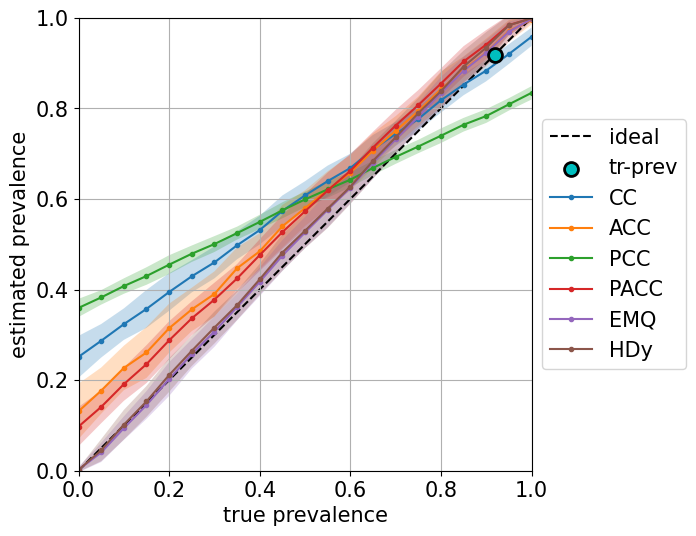

In [63]:
qp.plot.binary_diagonal(method_names, true_prevs, estim_prevs, train_prev=tr_prevs[0])

It is sometimes convenient to analye the distribution of the errors produced by each quantifier. Distributions are sometimes displayed in terms of box-plots in statistics. A box-plot shows some Quantiles, the mean, median, and the outliers of the distribution in compact form. In this case we display the "bias", which is the signed error with respect to the true positive prevalence.

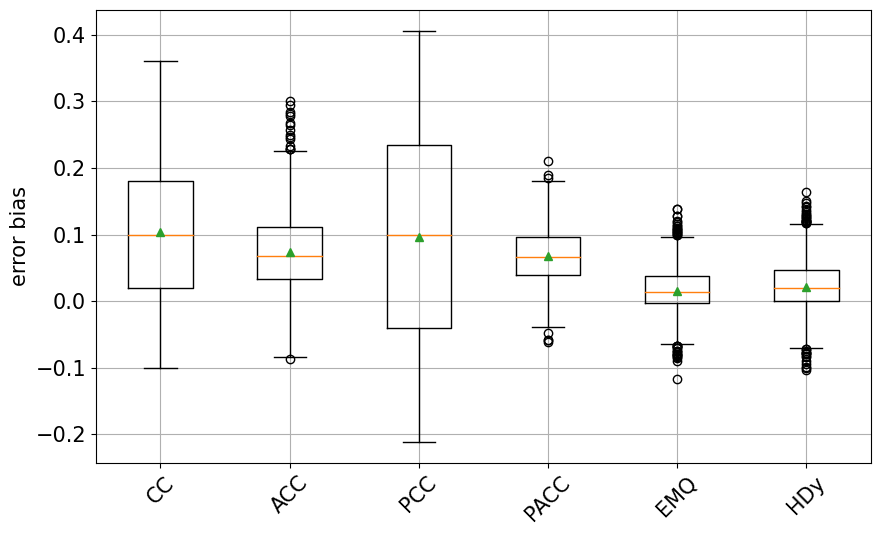

In [64]:
qp.plot.binary_bias_global(method_names, true_prevs, estim_prevs)

It could be helpful to analyze the error distribution by regions of prevalence. In this case, we bin together all results that belong to the [0-0.2] interval, [0.2-0.4] interval, and so on an so forth, and generate box-plots for each region. Something that jumps to the eye here is that methods like EMQ and HDy are not particularly affected by the region in which they operate, while methods like CC and PCC are strongly biased, because their error distributions are way different depending on the region of the prevalence spectrum in which these have been tested.

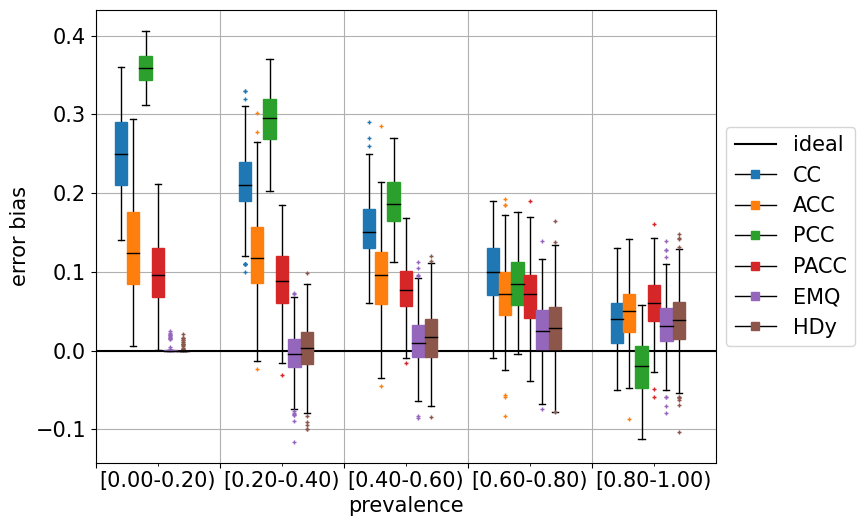

In [65]:
qp.plot.binary_bias_bins(method_names, true_prevs, estim_prevs)

These plots are convenient in binary problems only, although one can generate different binary plot for each of the classes in a single-label setting. However, in single-label settings it is preferable to display the quantification error as a function of the test shift. That is, we might be interested in analyzing whether our quantifier behaves well or not in a region of the space in which the test shift was high, with respect to the training prevalence, or if our quantifier only behaves robustly when the shift is low. The error-by-drift plot does exactly this.

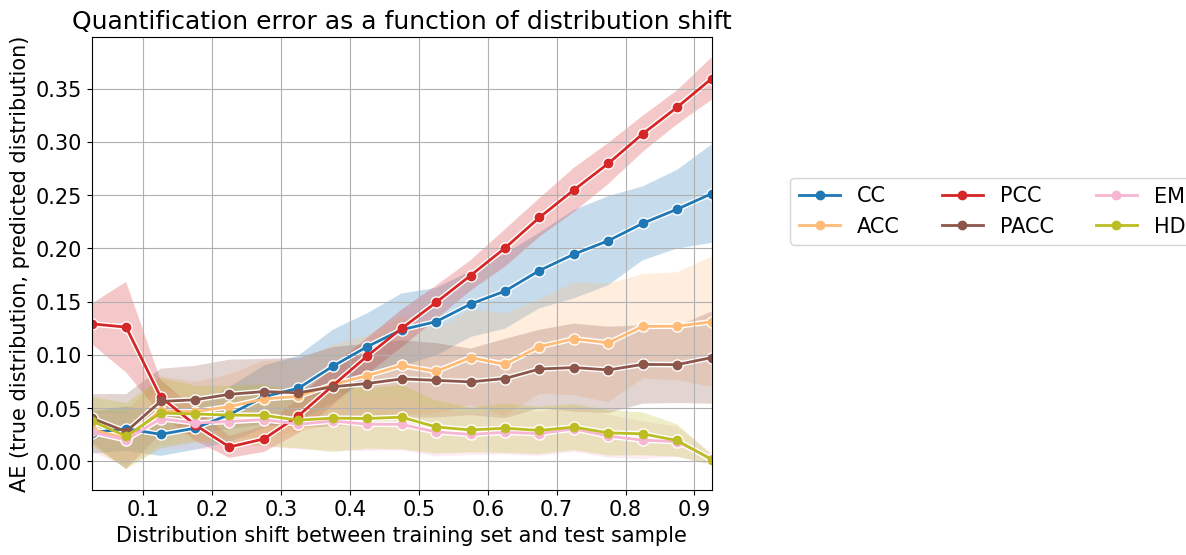

In [66]:
qp.plot.error_by_drift(method_names, true_prevs, estim_prevs, tr_prevs, show_density=False, show_std=True)

Finally, I would like to show you how to import your own datasets, so that you can apply the quantification machinery to your problems and quicky get some results.

For this example, I will assume you have some data stored in your disk, and that you simply want to integrate them into QuaPy. Let us assume that these datasets are simply the files we used in our first lecture, concerning Amazon reviews labelled by sentiment polarity. For simplicity, let simply download anew this dataset.

In [71]:
import quapy as qp

!pip install gdown

from google.colab import drive
drive.mount('/content/drive')

!gdown 1vyiy9qmd4tLvk3KAAquVMpcxVy0kLH1-

!unzip datasets.zip

!rm datasets.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive
Downloading...
From: https://drive.google.com/uc?id=1vyiy9qmd4tLvk3KAAquVMpcxVy0kLH1-
To: /content/datasets.zip
100% 4.99M/4.99M [00:00<00:00, 227MB/s]
Archive:  datasets.zip
   creating: datasets/
   creating: datasets/kindle/
  inflating: datasets/kindle/train.txt  
  inflating: datasets/kindle/test.txt  


Now, all you have to do is to implement a function that takes the path to the file as input, and that returns a list of instances and a list of labels. If you can write such a function, then QuaPy will automatically use your function to instantiate a Dataset in a way QuaPy can handle. 
From here on, everything is just as before.

In [72]:
train_path = './datasets/kindle/train.txt'
test_path = './datasets/kindle/test.txt'

def my_custom_loader(path):
    all_sentences, all_labels = [], []
    for line in tqdm(open(path, 'rt').readlines(), f'loading {path}'):
        label, sentence = line.split('\t')
        sentence = sentence.strip()
        label = int(label)
        if sentence:
            all_sentences.append(sentence)
            all_labels.append(label)
    return all_sentences, all_labels

data = qp.data.Dataset.load(train_path, test_path, my_custom_loader)

loading ./datasets/kindle/test.txt: 100%|██████████| 21591/21591 [00:00<00:00, 294032.98it/s]


In [73]:
training, test = dataset.train_test

model = qp.method.aggregative.PACC(LogisticRegression())
model.fit(training)

estim_prevalence = model.quantify(test.instances)
true_prevalence  = test.prevalence()

error = qp.error.mae(true_prevalence, estim_prevalence)

print(f'Mean Absolute Error (MAE)={error:.3f}')

Mean Absolute Error (MAE)=0.030
